# Fit global epistasis models to functional scores for each selection to get mutation functional effects

This notebook is parameterized by `papermill`.
The next cell is tagged as `parameters` to get the passed parameters.

In [1]:
# this cell is tagged parameters for `papermill` parameterization
func_scores = None
func_effects = None
global_epistasis_params = None
threads = None

In [2]:
# Parameters
global_epistasis_params = {
    "clip_lower": "median_stop",
    "clip_upper": None,
    "collapse_identical_variants": False,
}
selection = "LibA-220302-293T_ACE2-1"
func_scores = "results/func_scores/LibA-220302-293T_ACE2-1_func_scores.csv"
threads = 1

Import Python modules.
We use `multidms` for the fitting:

In [3]:
import dms_variants.codonvarianttable

import matplotlib.pyplot as plt

import multidms

import pandas as pd

In [4]:
import os

os.chdir("../test_example")

Read and clip functional scores:

In [5]:
func_scores_df = (
    pd.read_csv(func_scores, na_filter=None)
    .assign(condition=selection)
    .pipe(dms_variants.codonvarianttable.CodonVariantTable.classifyVariants)
)

median_stop = func_scores_df.query("variant_class == 'stop'")["func_score"].median()

for bound in ["upper", "lower"]:
    clip = global_epistasis_params[f"clip_{bound}"]
    if clip is None:
        print(f"No clipping on {bound} bound of functional scores")
    else:
        if clip == "median_stop":
            if pd.isnull(median_stop):
                raise ValueError(f"{median_stop=}")
            clip = median_stop
        assert isinstance(clip, (int, float)), clip
        print(f"Clipping {bound} bound of functional scores to {clip}")
        func_scores_df["func_score"] = func_scores_df["func_score"].clip(**{bound: clip})

No clipping on upper bound of functional scores
Clipping lower bound of functional scores to -4.85


Initialize the data for `multidms`:

In [6]:
data = multidms.MultiDmsData(
    variants_df=func_scores_df,
    reference=selection,
    alphabet=multidms.AAS_WITHSTOP_WITHGAP,
    collapse_identical_variants=global_epistasis_params["collapse_identical_variants"],
    letter_suffixed_sites=True,
    verbose=True,
    nb_workers=threads,
)

inferring site map for LibA-220302-293T_ACE2-1
INFO: Pandarallel will run on 1 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.
Converting mutations for LibA-220302-293T_ACE2-1
is reference, skipping


Now initialize the `multidms` model and fit it:

In [7]:
# initialize with default params, which give sigmoid global epistasis function
model = multidms.MultiDmsModel(data)

model.fit()

Look at accuracy of predictionss and the global epistasis fit:

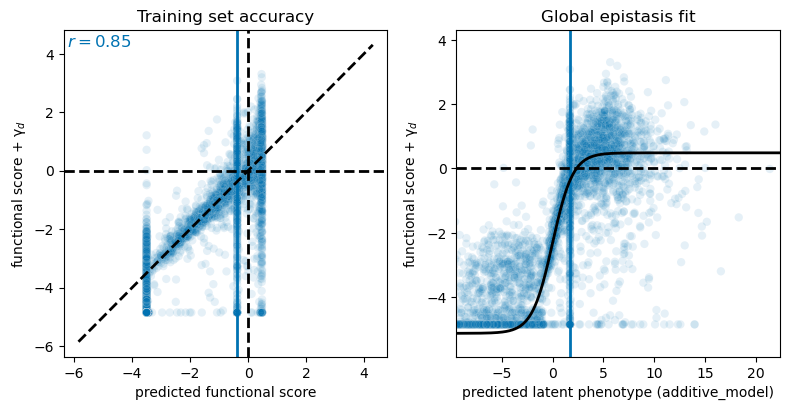

In [8]:
fig, ax = plt.subplots(1, 2, figsize=[8,4])
model.plot_epistasis(ax=ax[1], alpha=0.1, show=False, legend=False)
model.plot_pred_accuracy(ax=ax[0], alpha=0.1, show=False, legend=False)
ax[1].set_title("Global epistasis fit")
ax[0].set_title("Training set accuracy")
plt.show()

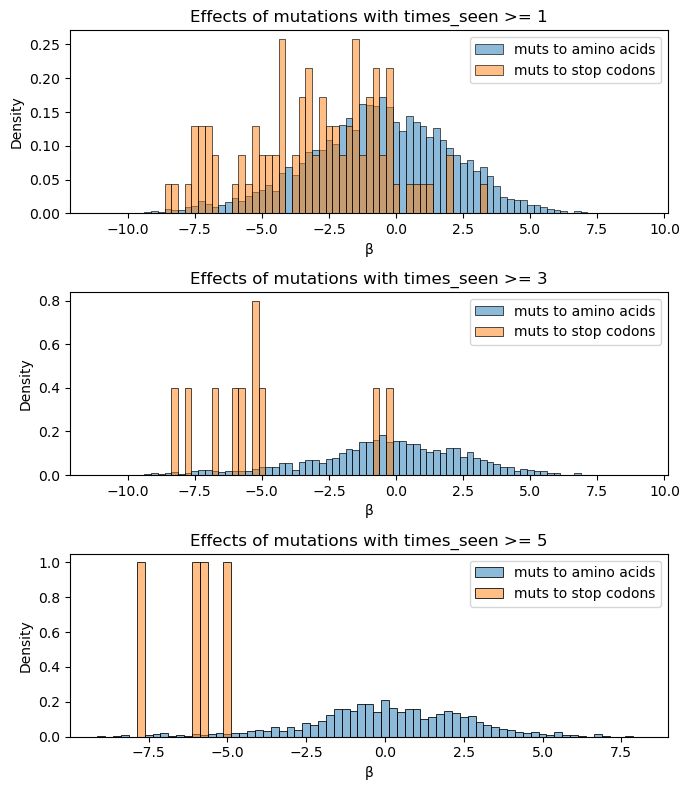

In [9]:
fig, axes = plt.subplots(3, 1, figsize=[7, 8])
for times_seen, ax in zip([1, 3, 5], axes):
    model.plot_param_hist("β", ax=ax, show=False, times_seen_threshold=times_seen)
    ax.legend()
    ax.set_title(
        f"Latent-phenotype effects of mutations with times_seen >= {times_seen}"
    )
plt.tight_layout()
plt.show()

In [10]:
model.mutations_df.columns

Index(['mutation', 'wts', 'sites', 'muts',
       'times_seen_LibA-220302-293T_ACE2-1', 'β'],
      dtype='object')

In [15]:
mut_effects = (
    model.mutations_df
    .rename(
        columns={
            "β": "latent_phenotype_effect",
        }
    )
)

mut_effects

,mutation,wts,sites,muts,times_seen_LibA-220302-293T_ACE2-1,latent_phenotype_effect
0,M1I,M,1,I,1,-0.450409
1,M1K,M,1,K,1,-5.812850
2,M1L,M,1,L,1,-2.980201
3,M1V,M,1,V,3,-6.644840
4,F2L,F,2,L,3,3.112728
...,...,...,...,...,...,...
5091,S1252W,S,1252,W,2,-1.025079
5092,S1252Y,S,1252,Y,4,-4.528130
5093,S1252-,S,1252,-,2,-7.041424
5094,*1253R,*,1253,R,5,0.076779
